Importy:

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics import YOLO
import os
import shutil
from sklearn.model_selection import train_test_split
import yaml
import random
import cv2

Import konkretnego modelu YOLO:

In [3]:
model = YOLO('yolov8n.pt')
model.info()

YOLOv8n summary: 225 layers, 3,157,200 parameters, 0 gradients, 8.9 GFLOPs


(225, 3157200, 0, 8.8575488)

I teraz zobaczymy czy mi znajdzie psa i kota:


image 1/1 d:\studia\Image-Recognition-Methods\lab4\pieskot.jpg: 448x640 1 cat, 1 dog, 1 potted plant, 1 teddy bear, 226.7ms
Speed: 4.0ms preprocess, 226.7ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


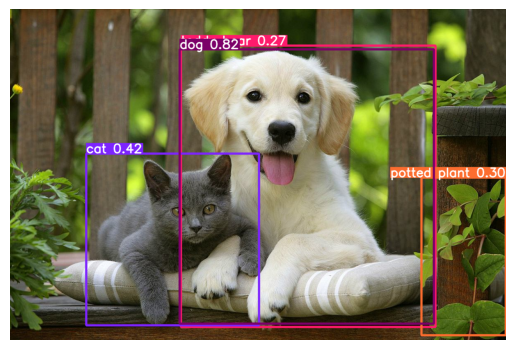

In [26]:
results = model('pieskot.jpg')

predicted_image = results[0].plot()
predicted_image_rgb = np.asarray(predicted_image)[..., ::-1]

plt.imshow(predicted_image_rgb)
plt.axis('off')
plt.show()

In [5]:
class_descriptions = pd.read_csv('Images/class-descriptions-boxable.csv', header=None)

food_class_id = class_descriptions[class_descriptions[1].str.contains('Food', case=False, na=False)][0].values[0]

print(f"ID klasy 'Food': {food_class_id}")

train_labels = pd.read_csv('Images/train-annotations-human-imagelabels-boxable.csv')
val_labels = pd.read_csv('Images/validation-annotations-human-imagelabels-boxable.csv')
test_labels = pd.read_csv('Images/test-annotations-human-imagelabels-boxable.csv')

train_food_images = train_labels[train_labels['LabelName'] == food_class_id]['ImageID']
val_food_images = val_labels[val_labels['LabelName'] == food_class_id]['ImageID']
test_food_images = test_labels[test_labels['LabelName'] == food_class_id]['ImageID']

with open('food_images.txt', 'w') as f:
    for image_id in train_food_images:
        f.write(f'train/{image_id}\n')
    for image_id in val_food_images:
        f.write(f'validation/{image_id}\n')
    for image_id in test_food_images:
        f.write(f'test/{image_id}\n')


ID klasy 'Food': /m/01_bhs


In [7]:
images_txt = 'food_images.txt'
source_folder = 'downloaded_food_images'
output_folder = 'dataset_split'

train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'val')
test_folder = os.path.join(output_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

with open(images_txt, 'r') as file:
    image_files = [line.strip() for line in file.readlines()]

train_files, temp_files = train_test_split(image_files, test_size=0.3, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

def move_files(file_list, destination_folder):
    for file_name in file_list:
        if "train/" in file_name:
            file_name = file_name.replace("train/", "")
        if "test/" in file_name:
            file_name = file_name.replace("test/", "")
        if "validation/" in file_name:
            file_name = file_name.replace("validation/", "")
        file_name += ".jpg"
        source_path = os.path.join(source_folder, file_name)
        destination_path = os.path.join(destination_folder, file_name)
        if os.path.exists(source_path):
            shutil.copy(source_path, destination_path)
        else:
            print(f"Plik {file_name} nie został znaleziony w folderze {source_folder}.")

move_files(train_files, train_folder)
move_files(val_files, val_folder)
move_files(test_files, test_folder)

print("Podział danych zakończony!")
print(f"Train: {len(train_files)} plików")
print(f"Val: {len(val_files)} plików")
print(f"Test: {len(test_files)} plików")


Plik 118fdfa46ac0fa99.jpg nie został znaleziony w folderze downloaded_food_images.
Plik e6b96d1213239d0d.jpg nie został znaleziony w folderze downloaded_food_images.
Plik 772fc3c83a539c99.jpg nie został znaleziony w folderze downloaded_food_images.
Plik 2c045a45eef34f4c.jpg nie został znaleziony w folderze downloaded_food_images.
Plik f0bdc291c1f3c032.jpg nie został znaleziony w folderze downloaded_food_images.
Plik 1271996ca2e325d4.jpg nie został znaleziony w folderze downloaded_food_images.
Plik 11ea130c05a605fe.jpg nie został znaleziony w folderze downloaded_food_images.
Plik f8c7f663238dc774.jpg nie został znaleziony w folderze downloaded_food_images.
Plik e130497c6694a914.jpg nie został znaleziony w folderze downloaded_food_images.
Plik 630e94c080fb7ca6.jpg nie został znaleziony w folderze downloaded_food_images.
Plik 7a5a02c8dfe5f3b8.jpg nie został znaleziony w folderze downloaded_food_images.
Plik ecf34d6dc942d0fc.jpg nie został znaleziony w folderze downloaded_food_images.
Plik

In [6]:
labels_folder = os.path.join(output_folder, 'labels')
train_labels_folder = os.path.join(labels_folder, 'train')
val_labels_folder = os.path.join(labels_folder, 'val')
test_labels_folder = os.path.join(labels_folder, 'test')

annotations_path = "Images/oidv6-train-annotations-bbox.csv"
annotations = pd.read_csv(annotations_path)

os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(val_labels_folder, exist_ok=True)
os.makedirs(test_labels_folder, exist_ok=True)

def generate_labels(image_files, label_folder):
    for file_path in image_files:
        image_id = os.path.basename(file_path).split('.')[0]
        label_file = os.path.join(label_folder, f"{image_id}.txt")

        image_annotations = annotations[annotations['ImageID'] == image_id]

        with open(label_file, 'w') as f:
            for _, row in image_annotations.iterrows():
                x_center = (row['XMax'] + row['XMin']) / 2
                y_center = (row['YMax'] + row['YMin']) / 2
                width = row['XMax'] - row['XMin']
                height = row['YMax'] - row['YMin']

                f.write(f"0 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")



train_files = [os.path.basename(f).replace("train/", "").replace("validation/", "").replace("test/", "") for f in train_files]
val_files = [os.path.basename(f).replace("train/", "").replace("validation/", "").replace("test/", "") for f in val_files]
test_files = [os.path.basename(f).replace("train/", "").replace("validation/", "").replace("test/", "") for f in test_files]

generate_labels(train_files, train_labels_folder)
generate_labels(val_files, val_labels_folder)
generate_labels(test_files, test_labels_folder)


NameError: name 'output_folder' is not defined

Generacja YAML'a:

In [8]:
data = {
    'train': 'D:/studia/Image-Recognition-Methods/lab4/dataset_split/train/images',
    'val': 'D:/studia/Image-Recognition-Methods/lab4/dataset_split/val/images',
    'nc': 1,
    'names': ['Food']
}

with open('dataset.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

print("Plik 'dataset.yaml' został wygenerowany.")


Plik 'dataset.yaml' został wygenerowany.


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = model.train(data="dataset.yaml", epochs=10, batch=16, device=device)

New https://pypi.org/project/ultralytics/8.3.39 available  Update with 'pip install -U ultralytics'
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_

train: Scanning D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\labels... 20064 images, 1578 backgrounds, 0 corrupt: 100%|██████████| 20064/20064 [00:16<00:00, 1212.22it/s]

train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\000060e3121c7305.jpg: 1 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\0006aea8166f4cd8.jpg: 1 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\0054d8bdd83c2537.jpg: 1 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\008661f71363796c.jpg: 1 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\00c5c6c46729b759.jpg: 2 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\00db865b6604cc20.jpg: 1 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\images\01c102398f293c95.jpg: 1 duplicate labels removed
train: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_spli

train: New cache created: D:\studia\Image-Recognition-Methods\lab4\dataset_split\train\labels.cache


val: Scanning D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\labels... 4299 images, 330 backgrounds, 0 corrupt: 100%|██████████| 4299/4299 [00:03<00:00, 1120.59it/s]

val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\00037418480b82d5.jpg: 1 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\00356f12c27a5aa2.jpg: 1 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\0318a9b9ef43e8da.jpg: 1 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\0b77fdd4b201e3d8.jpg: 1 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\0f96b099aad02d78.jpg: 2 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\1463c7e454e12781.jpg: 1 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\1cc6536d7cf2d56e.jpg: 2 duplicate labels removed
val: WARNING  D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\images\2928da1343ad1d78.

val: New cache created: D:\studia\Image-Recognition-Methods\lab4\dataset_split\val\labels.cache
Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.28G      1.798      2.037      1.801        121        640: 100%|██████████| 1254/1254 [02:37<00:00,  7.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:21<00:00,  6.40it/s]


                   all       4299      33807      0.424      0.355      0.316      0.164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      3.88G      1.562      1.777      1.619         74        640: 100%|██████████| 1254/1254 [02:32<00:00,  8.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.90it/s]


                   all       4299      33807      0.461      0.368      0.348       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      3.52G      1.528      1.742      1.606        144        640: 100%|██████████| 1254/1254 [02:28<00:00,  8.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.97it/s]


                   all       4299      33807      0.468      0.369      0.355      0.197

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      4.07G      1.494      1.692      1.574        202        640: 100%|██████████| 1254/1254 [02:29<00:00,  8.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.88it/s]


                   all       4299      33807      0.477      0.389      0.373       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      3.54G      1.456      1.635      1.541        140        640: 100%|██████████| 1254/1254 [02:24<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:18<00:00,  7.26it/s]


                   all       4299      33807      0.471      0.397      0.379      0.218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      4.42G      1.423      1.594      1.516        184        640: 100%|██████████| 1254/1254 [02:19<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:18<00:00,  7.38it/s]


                   all       4299      33807      0.492      0.398      0.387      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      4.02G      1.395      1.558      1.493        122        640: 100%|██████████| 1254/1254 [02:35<00:00,  8.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.79it/s]


                   all       4299      33807        0.5      0.409      0.398      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      4.19G      1.371      1.517      1.476        111        640: 100%|██████████| 1254/1254 [02:33<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.94it/s]


                   all       4299      33807      0.501      0.411      0.403      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      3.61G      1.351      1.485      1.453        205        640: 100%|██████████| 1254/1254 [02:32<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.96it/s]


                   all       4299      33807      0.504      0.425      0.412      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      3.78G      1.329      1.452      1.438        143        640: 100%|██████████| 1254/1254 [02:32<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:19<00:00,  6.97it/s]


                   all       4299      33807       0.51      0.425      0.416      0.249

10 epochs completed in 0.480 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.38  Python-3.12.4 torch-2.4.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 135/135 [00:22<00:00,  6.09it/s]


                   all       4299      33807      0.509      0.426      0.416      0.249
Speed: 0.1ms preprocess, 1.2ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train3


Wykres funkcji kosztu:

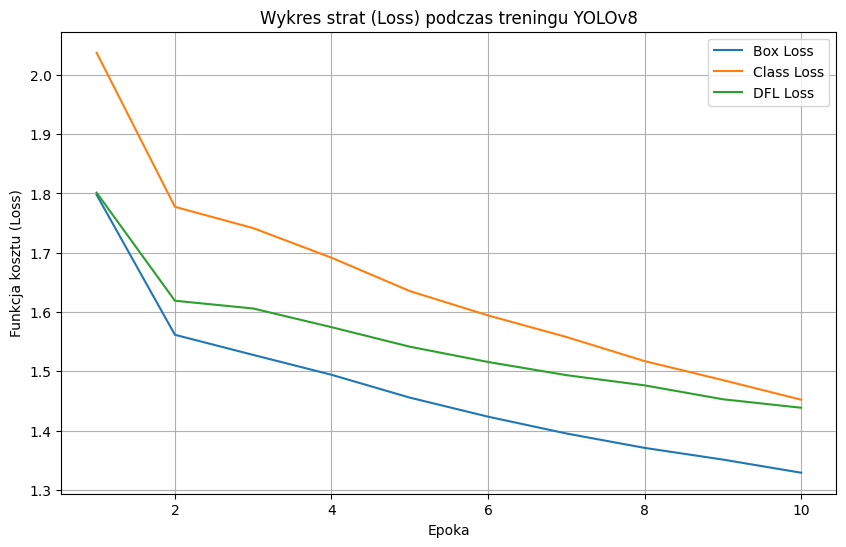

In [11]:
results_path = "runs/detect/train3/results.csv"

data = pd.read_csv(results_path)
data.columns = data.columns.str.strip()

plt.figure(figsize=(10, 6))
plt.plot(data['epoch'], data['train/box_loss'], label='Box Loss')
plt.plot(data['epoch'], data['train/cls_loss'], label='Class Loss')
plt.plot(data['epoch'], data['train/dfl_loss'], label='DFL Loss')
plt.xlabel('Epoka')
plt.ylabel('Funkcja kosztu (Loss)')
plt.title('Wykres strat (Loss) podczas treningu YOLOv8')
plt.legend()
plt.grid()
plt.show()

A teraz przetestuję przetrenowany model na kilku zdjęciach z zbioru testowego:


image 1/1 d:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\2e401a95b313aa99.jpg: 448x640 6 Foods, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


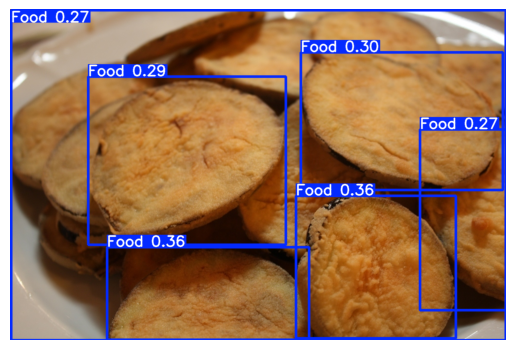


image 1/1 d:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\9a47a1ca96f7dc23.jpg: 448x640 2 Foods, 5.0ms
Speed: 1.0ms preprocess, 5.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


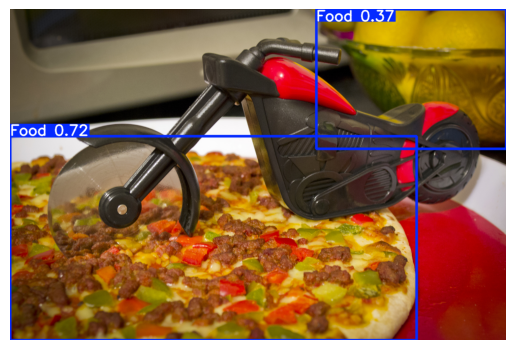


image 1/1 d:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\56446c474989f823.jpg: 448x640 6 Foods, 3.5ms
Speed: 2.0ms preprocess, 3.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


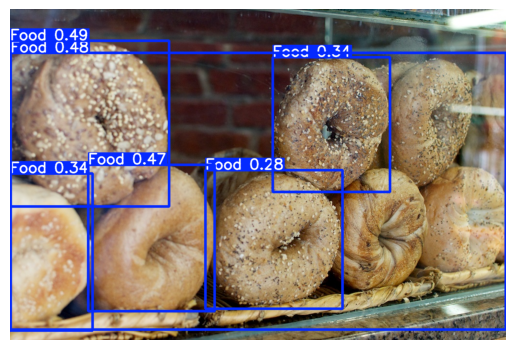


image 1/1 d:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\828a8eb0d3a03395.jpg: 640x480 1 Food, 4.6ms
Speed: 1.0ms preprocess, 4.6ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 480)


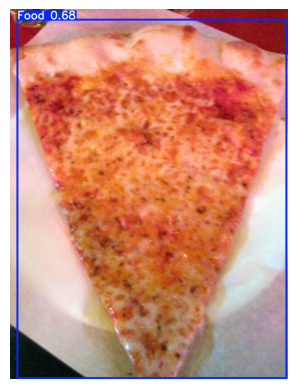


image 1/1 d:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\d508dd5e6f3f71da.jpg: 480x640 1 Food, 4.1ms
Speed: 1.0ms preprocess, 4.1ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


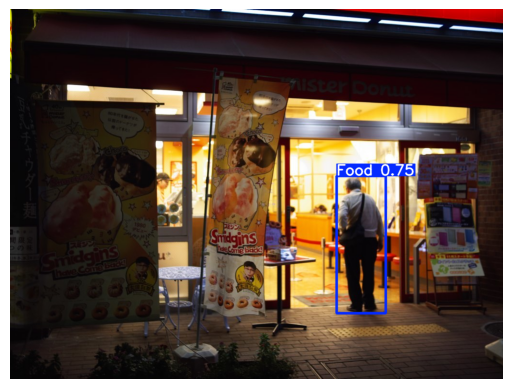

In [28]:
test_images_path = "D:/studia/Image-Recognition-Methods/lab4/dataset_split/test/images"
trained_model = YOLO('runs/detect/train3/weights/best.pt')

def get_random_image_names(folder_path, num_images=5):
    all_files = [f for f in os.listdir(folder_path) if f.endswith(('jpg'))]
    selected_files = random.sample(all_files, num_images)
    return selected_files

random_images = get_random_image_names(test_images_path)



for image in random_images:
    results = trained_model("./dataset_split/test/images/" + image)

    predicted_image = results[0].plot()
    predicted_image_rgb = np.asarray(predicted_image)[..., ::-1]

    plt.imshow(predicted_image_rgb)
    plt.axis('off')
    plt.show()

Teraz dodam rozmycie za pomocą Gaussian Blur'dostępnego w bibliotece OpenCV:


image 1/1 D:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\2e401a95b313aa99.jpg: 448x640 6 Foods, 5.3ms
Speed: 79.5ms preprocess, 5.3ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


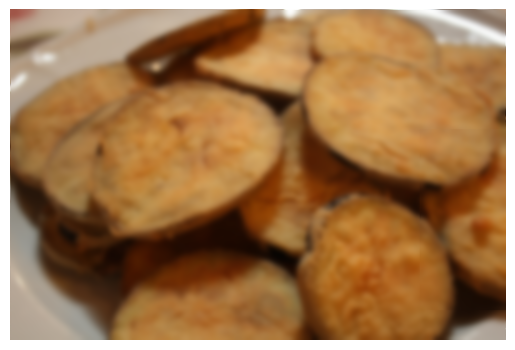


image 1/1 D:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\9a47a1ca96f7dc23.jpg: 448x640 2 Foods, 3.0ms
Speed: 1.5ms preprocess, 3.0ms inference, 2.0ms postprocess per image at shape (1, 3, 448, 640)


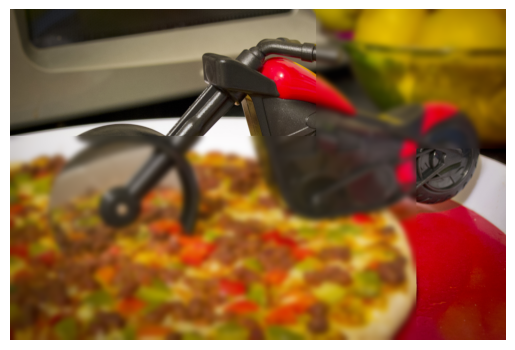


image 1/1 D:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\56446c474989f823.jpg: 448x640 6 Foods, 3.5ms
Speed: 1.5ms preprocess, 3.5ms inference, 0.5ms postprocess per image at shape (1, 3, 448, 640)


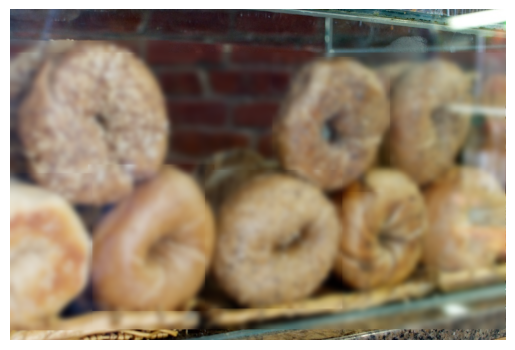


image 1/1 D:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\828a8eb0d3a03395.jpg: 640x480 1 Food, 3.5ms
Speed: 1.0ms preprocess, 3.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


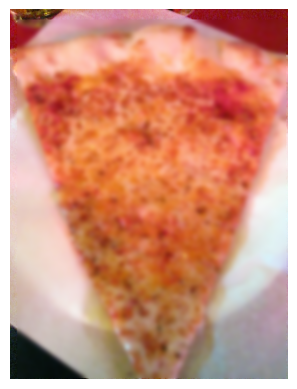


image 1/1 D:\studia\Image-Recognition-Methods\lab4\dataset_split\test\images\d508dd5e6f3f71da.jpg: 480x640 1 Food, 4.9ms
Speed: 1.0ms preprocess, 4.9ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


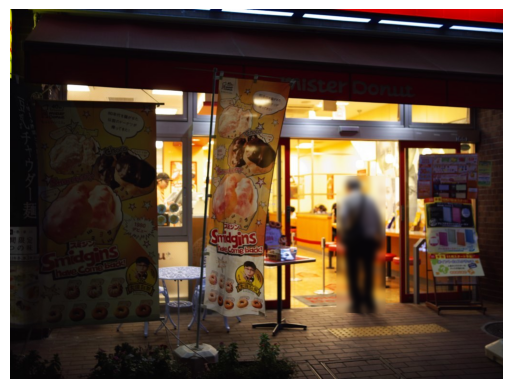

In [34]:
def apply_blur(image, boxes, blur_size=(35, 35)):
    image_np = np.array(image)

    blurred_image = image_np.copy()

    for box in boxes:
        x1, y1, x2, y2 = map(int, box)
        rectangle = image_np[y1:y2, x1:x2]
        rectangle_blurred = cv2.GaussianBlur(rectangle, blur_size, 0) 
        blurred_image[y1:y2, x1:x2] = rectangle_blurred
    return blurred_image

for image in random_images:
    image_path = os.path.join(test_images_path, image)
    results = trained_model(image_path)

    boxes = results[0].boxes.xyxy.cpu().numpy()
    classes = results[0].boxes.cls.cpu().numpy()
    food_boxes = boxes[classes == 0]

    original_image = Image.open(image_path).convert("RGB")
    blurred_image = apply_blur(original_image, food_boxes)

    plt.imshow(blurred_image)
    plt.axis('off')
    plt.show()